In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
import keras
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import AveragePooling1D, Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten, SpatialDropout1D
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import AttentionLayer as Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix, getSpansByToxicWords
from keras import Sequential
from test_sentence import preprocess_lstm, test_lime, vectorize, Transform, getPredictedWordsFromSentence, test_lime_2
import pickle
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import sklearn

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [100]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/patrycja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [101]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_train.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [102]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,diff,toxicity_sentence
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1,"[moron, bigot]",Because he's a moron and a bigot. It's not any...,"[because hes a moron and a bigot., its not any...","[10, 36]","[1.0, 0.0]"
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1,[idiots],How about we stop protecting idiots and let na...,[how about we stop protecting idiots and let n...,[],"[1.0, 0.0]"
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1,[idiots],"If people were smart, they would Boycott th...","[if people were smart, they would boycott t...",[],[1.0]
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1,[stupid],Trump Claimed that Russia will never invade th...,[trump claimed that russia will never invade t...,[],[1.0]
4,[],as long as your willing to pay a lot more for ...,0,[],As long as your willing to pay a lot more for ...,[as long as your willing to pay a lot more for...,[148],"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
685,"[129, 130, 131, 132, 133, 134]",but ... trumps not bluffing. hes prepared to g...,1,[stupid],But ... Trump's not bluffing. He's prepared to...,"[but ... trumps not bluffing., hes prepared to...","[13, 32, 151, 159, 166]","[0.0, 0.0, 0.0, 1.0, 0.0]"
686,"[126, 127, 128, 129, 130, 131]",cant believe the limited knowledge of this art...,1,[stupid],Can't believe the limited knowledge of this Ar...,[cant believe the limited knowledge of this ar...,[3],"[0.0, 1.0]"
687,"[24, 25, 26, 27, 28, 29]",i think it conservative idiots who cannot reac...,1,[idiots],I think it conservative idiots who cannot reac...,[i think it conservative idiots who cannot rea...,[],[1.0]
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",youre an id*ot...go away.,1,[youre an id*ot],You're an id*ot...Go away.,[youre an id*ot...go away.],[3],[1.0]


In [103]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###

In [104]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [105]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [106]:
#filter stop words
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#for i, w in enumerate(sentences):
#    sentences[i] = [w for w in sentences[i] if not w in stop_words]

In [107]:
sentences = [x for x in sentences if x!=[]]

In [108]:
### save toknizer to file so that it could be used again
import pickle

# saving

# with open('tokenizer_nn.pickle', 'wb') as handle:

#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [110]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000)

In [111]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [112]:
absent_words = 0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=0
        absent_words+=1

In [113]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [114]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  67  118    4  150    2    4  877    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  54   18   65   55 1909   84    8    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  52   44   37  133  878   81    2  139  879 1202  101 1910    3    1
  1911 1203    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  37   45  129 1912   35 1204   13    1  880 1205    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  36   26   71  676   19   49 1206   12  561 1913   29   19   10   18
   676   34 1914 1915   39   12   66  134 1916  278    1   81   13    4
  1207    0    0    0    0  

In [115]:
y_softmax_train = np.zeros((y_train.shape[0], 2))
y_softmax_val = np.zeros((y_val.shape[0], 2))

In [116]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [117]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

### Build model

In [23]:
from keras.engine.topology import Layer, InputSpec
from keras import backend as T

class TemporalMeanPooling(Layer):
    """
This is a custom Keras layer. This pooling layer accepts the temporal
sequence output by a recurrent layer and performs temporal pooling,
looking at only the non-masked portion of the sequence. The pooling
layer converts the entire variable-length hidden vector sequence
into a single hidden vector, and then feeds its output to the Dense
layer.

input shape: (nb_samples, nb_timesteps, nb_features)
output shape: (nb_samples, nb_features)
"""
def __init__(self, **kwargs):
    super(TemporalMeanPooling, self).__init__(**kwargs)
    self.supports_masking = True
    self.input_spec = [InputSpec(ndim=3)]

def get_output_shape_for(self, input_shape):
    return (input_shape[0], input_shape[2])

def call(self, x, mask=None): #mask: (nb_samples, nb_timesteps)
    if mask is None:
        mask = T.mean(T.ones_like(x), axis=-1)
    ssum = T.sum(x,axis=-2) #(nb_samples, np_features)
    mask = T.cast(mask,T.floatx())
    rcnt = T.sum(mask,axis=-1,keepdims=True) #(nb_samples)
    return ssum/rcnt
    #return rcnt

def compute_mask(self, input, mask):
    return None


In [209]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(LSTM(100,dropout=0.7, recurrent_dropout = 0.7))
model.add(TemporalMeanPooling())
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1388400   
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               160400    
_________________________________________________________________
temporal_mean_pooling_35 (Te (None, 100)               0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                 202       
Total params: 1,549,002
Trainable params: 1,549,002
Non-trainable params: 0
_________________________________________________________________


In [210]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1388400   
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               160400    
_________________________________________________________________
temporal_mean_pooling_35 (Te (None, 100)               0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                 202       
Total params: 1,549,002
Trainable params: 1,549,002
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
2/2 [==============================] - 1s 466ms/step - loss: 0.6901 - acc: 0.5038 - val_loss: 0.6697 - val_acc: 0.6132
Epoch 2/25
2/2 [==============================] - 1s 409ms/step - loss: 0.6786 - acc: 0.5928 - val_loss: 0.6763 - val_acc: 0.6132
Epoch 3/25
2/2 [==============================] - 1s 385ms/step - loss: 0.6778 - acc: 0.5953 - val_loss: 0.6682 - val_acc: 0.6132
Epoch 4/25
2/2 [==============================] - 1s 346ms/step - loss: 0.6747 - acc: 0.5953 - val_loss: 0.6667 - val_acc: 0.6132
Epoch 5/25
2/2 [==============================] - 1s 324ms/step - loss: 0.6725 - acc: 0.5953 - val_loss: 0.6693 - val_acc: 0.6132
Epoch 6/25
2/2 [==============================] - 1s 323ms/step - loss: 0.6719 - acc: 0.5959 - val_loss: 0.6676 - val_acc: 0.6132
Epoch 7/25
2/2 [==============================] - 1s 343ms/step - loss: 0.6723 - acc: 0.5972 - val_loss: 0.6667 - val_acc: 0.6132
Epoch 8/25
2/2 [==============================] - 1s 317ms/step - loss: 0.6675 - acc: 0.59

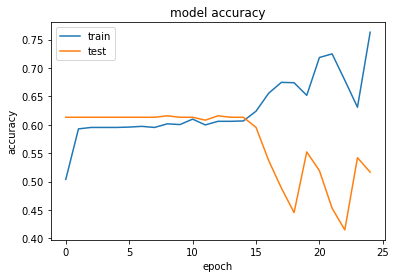

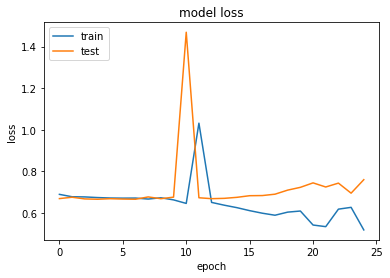

In [211]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=25, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [214]:
model.save('lstm_pooling')

INFO:tensorflow:Assets written to: lstm_pooling/assets


In [215]:
predictions = model.predict(x_train)
predictions = [np.argmax(i) for i in predictions ]

print(sklearn.metrics.classification_report(y_train, predictions))

predictions_val = model.predict(x_val)
predictions_val = [np.argmax(i) for i in predictions_val ]

print(sklearn.metrics.classification_report(y_val, predictions_val))


              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81       933
         1.0       0.69      0.92      0.79       641

    accuracy                           0.80      1574
   macro avg       0.81      0.82      0.80      1574
weighted avg       0.83      0.80      0.80      1574

              precision    recall  f1-score   support

         0.0       0.64      0.48      0.55       241
         1.0       0.41      0.57      0.48       152

    accuracy                           0.52       393
   macro avg       0.53      0.53      0.51       393
weighted avg       0.55      0.52      0.52       393



### Evaluation

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [4]:
## load data
test_data_semeval = SemEvalData(MAX_WORD_NUM)
test_data_semeval.load_data("data/tsd_trial.csv")
test_df_preprocessed = test_data_semeval.preprocess()

In [5]:
result = test_df_preprocessed
test_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

test_df = pd.DataFrame (test_data, columns = ['sentence','toxicity_sentence'])

In [219]:
model = keras.models.load_model("lstm_pooling")

In [220]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1388400   
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               160400    
_________________________________________________________________
temporal_mean_pooling_35 (Te (None, 100)               0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                 202       
Total params: 1,549,002
Trainable params: 1,549,002
Non-trainable params: 0
_________________________________________________________________


Adapting explanation to sentences

In [221]:
test_df_preprocessed["predicted_span_lstm"]=[test_lime(sentences) for sentences in test_df_preprocessed["original_text"] ]

[]
Instructions for updating:
Please use `model.predict()` instead.
[10, 11, 4, 5, 6, 7, 8, 44, 45, 46, 47, 48, 49]
[24, 25, 26, 27, 29, 30, 31, 32, 33, 57, 58, 59, 60, 61, 62, 63]


KeyboardInterrupt: 

In [12]:
test_df_preprocessed["Pscore_lstm"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(ps) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(ps))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span_lstm"]) ]

c:\users\julia\desktop\wedt\wedt-project\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
test_df_preprocessed["Rscore_lstm"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(s) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(s))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span_lstm"]) ]

c:\users\julia\desktop\wedt\wedt-project\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
test_df_preprocessed["Fscore_lstm"] = [ 0 if (p == 0 and r == 0)
    else 2 * p *r /(p + r) for p, r in zip(test_df_preprocessed["Pscore_lstm"], test_df_preprocessed["Rscore_lstm"] )]

c:\users\julia\desktop\wedt\wedt-project\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
test_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,diff,toxicity_sentence,predicted_span,Pscore,Rscore,Fscore
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1,"[moron, bigot]",Because he's a moron and a bigot. It's not any...,"[because hes a moron and a bigot., its not any...","[10, 36]","[1.0, 0.0]","[8, 9, 10, 11, 27, 28, 29, 30, 31, 21, 22, 23,...",0.588235,1.0,0.740741
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1,[idiots],How about we stop protecting idiots and let na...,[how about we stop protecting idiots and let n...,[],"[1.0, 0.0]","[0, 1, 2, 10, 11, 13, 14, 15, 16, 18, 19, 20, ...",0.000000,0.0,0.000000
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1,[idiots],"If people were smart, they would Boycott th...","[if people were smart, they would boycott t...",[],[1.0],[],0.000000,0.0,0.000000
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1,[stupid],Trump Claimed that Russia will never invade th...,[trump claimed that russia will never invade t...,[],[1.0],[],0.000000,0.0,0.000000
4,[],as long as your willing to pay a lot more for ...,0,[],As long as your willing to pay a lot more for ...,[as long as your willing to pay a lot more for...,[148],"[0.0, 0.0, 0.0]","[177, 178, 179, 180, 167, 168, 170, 171, 172, ...",0.000000,0.0,0.000000
5,"[8, 9, 10, 11, 12]",only an idiot would use and believe anything t...,1,[idiot],Only an idiot would use and believe anything t...,[only an idiot would use and believe anything ...,[],[1.0],"[14, 15, 16, 17, 18, 8, 9, 10, 11, 12, 28, 29,...",0.200000,1.0,0.333333
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",thanks a lot douchebag. youre the reason the p...,1,[o try to turn salem into some kind of new-stu...,Thanks a lot douchebag. You're the reason the ...,"[thanks a lot douchebag., youre the reason the...","[27, 467]","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]","[0, 1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19,...",0.000000,0.0,0.000000
7,[],kick all the non human criminal illegals out o...,0,[],kick all the non human criminal illegals out o...,[kick all the non human criminal illegals out ...,[],[0.0],[],1.000000,1.0,1.000000
8,"[38, 39, 40, 41, 42, 43]",because driving under ontario laws is stupid e...,1,[stupid],Because driving under Ontario laws is stupid e...,[because driving under ontario laws is stupid ...,[],[1.0],"[45, 46, 47, 48, 49, 50]",0.000000,0.0,0.000000
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",youre wrong. the delay between retirement and...,1,[dont make ignorant statements],You're wrong. The delay between retirement an...,"[youre wrong., the delay between retirement an...","[3, 264, 280]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[],0.000000,0.0,0.000000


In [16]:
F_score= np.mean(test_df_preprocessed["Fscore_lstm"])

In [17]:
F_score

0.11522633744855969

Attention model

In [6]:
test_df_preprocessed["predicted_span_at"]=[test_lime_2(sentences) for sentences in test_df_preprocessed["original_text"] ]

Instructions for updating:
Please use `model.predict()` instead.
[8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6]


InvalidArgumentError:  indices[11,33] = 8983 is not in [0, 4628)
	 [[node sequential_46/embedding/embedding_lookup (defined at /home/patrycja/anaconda3/envs/w2w/lib/python3.8/site-packages/sklearn/pipeline.py:464) ]] [Op:__inference_predict_function_27686]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_46/embedding/embedding_lookup:
 sequential_46/embedding/embedding_lookup/27419 (defined at /home/patrycja/anaconda3/envs/w2w/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function


In [ ]:
test_df_preprocessed["Pscore_at"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(ps) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(ps))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span_at"]) ]

In [ ]:
test_df_preprocessed["Rscore_at"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(s) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(s))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span_at"]) ]

In [ ]:
test_df_preprocessed["Fscore_at"] = [ 0 if (p == 0 and r == 0)
    else 2 * p *r /(p + r) for p, r in zip(test_df_preprocessed["Pscore_at"], test_df_preprocessed["Rscore_at"]

In [ ]:
F_score= np.mean(test_df_preprocessed["Fscore_at"])

### RandomForest

In [197]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(x_train, y_train)

<ipython-input-197-568d6d9acfdb>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


RandomForestClassifier(n_estimators=20, random_state=0)

In [198]:
predictions = model.predict(x_train)
predictions = [np.argmax(i) for i in predictions ]

print(sklearn.metrics.classification_report(y_train, predictions))

predictions_val = model.predict(x_val)
predictions_val = [np.argmax(i) for i in predictions_val ]

print(sklearn.metrics.classification_report(y_val, predictions_val))

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       933
         1.0       0.80      0.81      0.81       641

    accuracy                           0.84      1574
   macro avg       0.84      0.84      0.84      1574
weighted avg       0.84      0.84      0.84      1574

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62       241
         1.0       0.40      0.40      0.40       152

    accuracy                           0.54       393
   macro avg       0.51      0.51      0.51       393
weighted avg       0.54      0.54      0.54       393

